<a href="https://colab.research.google.com/github/joyceetng00/hello_cats/blob/master/XGboost_with_Conditionals_and_Multitask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
from __future__ import print_function
import time

# data processing
import pandas as pd
import numpy as np

# Modeling
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier

# Model Optimization 
# Install SigOpt's client library
import sigopt

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Create a Dataset

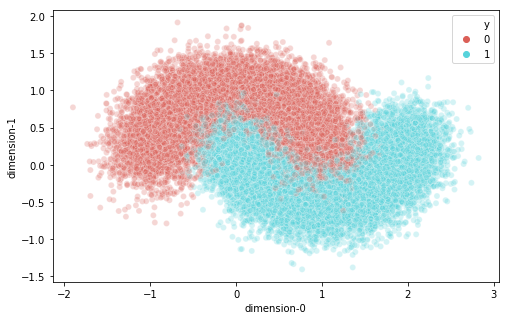

In [0]:
# Generate noisy moons data
X, y = make_moons(n_samples=25000, noise=0.25)
df = pd.DataFrame(X, columns=['dimension-0', 'dimension-1'])
df['dimension-0'] = X[:,0]
df['dimension-1'] = X[:,1]
df['y'] = y 

# Visualize moons
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='dimension-0', 
    y='dimension-1',
    hue='y',
    palette=sns.color_palette('hls', 2),
    data=df,
    legend='full',
    alpha=0.25
)

In [0]:
# split data 
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4)

In [0]:
# put your token here
api_token = "XXXXXXXXXXXXXX"

conn = sigopt.Connection(client_token=api_token)

In [0]:
project_name = "XGBoost Conditionals Demo"
project_id = "xgboost_cond_demo"

client_id = 9536

In [0]:
demo_metadata = dict(ip = "127.0.0.1",
                    model_type = "xgboost",
                    user = "Jane Doe",
                    git_url = "https://github.com/sigopt/sigopt-examples",
                    run_number = 89,
                    model_version = "2.9")

## SigOpt Experiment with Conditionals and Multitask

In [0]:
experiment = conn.experiments().create(
    
    name="xgboost multitask-conditional demo",
    
    # CONDTION ON BOOSTER TYPE
    conditionals = [
        dict(
            name = "booster",
            values = ["gbtree", "dart"],
        ),
    ],
    
    parameters=[
        
      # CONTINUOUS PARAMETERS  
      dict(name="lambda", bounds=dict(min=np.log(0.0001), max=np.log(1)), type="double"),
      dict(name="alpha", bounds=dict(min=np.log(0.0001), max=np.log(1)), type="double"),
      dict(name="gamma", bounds=dict(min=np.log(0.0001), max=np.log(1)), type="double"),
      dict(name="colsample_bytree",bounds=dict(min=0.00001, max=1), type="double"),
      dict(name="colsample_bylevel",bounds=dict(min=0.00001, max=1), type="double"),
      dict(name="colsample_bynode",bounds=dict(min=0.00001, max=1), type="double"),
      dict(name="subsample",bounds=dict(min=0.1, max=1.0), type="double"),
      dict(name="log_learning_rate", bounds=dict(min=np.log(0.01),max=np.log(1)), type="double"),
        
      # INTEGER PARAMETERS
      dict(name="max_depth", bounds=dict(min=5,max=10), type="int"),
      dict(name="n_estimators", bounds=dict(min=50,max=150), type="int"),
      dict(name="min_child_weight", bounds=dict(min=2,max=15), type="int"),
        
      # CATEGORICAL PARAMETERS
      # dict(name="booster", categorical_values=['gbtree', 'gblinear', 'dart'], type="categorical")
      # dict(name="tree_method", categorical_values=['auto', 'exact', 'approx', 'hist', 'gpu_hist'], type="categorical")
        
      # DART-SPECIFIC PARAMETERS
      dict(name="sample_type", categorical_values=['uniform', 'weighted'], type="categorical", conditions=dict(booster="dart")),
      dict(name="normalize_type", categorical_values=['tree', 'forest'], type="categorical", conditions=dict(booster="dart")),
      dict(name="rate_drop", bounds=dict(min=0.0, max=1.0), type="double", conditions=dict(booster="dart")),
      dict(name="skip_drop", bounds=dict(min=0.0, max=1.0), type="double", conditions=dict(booster="dart")),
  ],
   
  tasks=[
  dict(
    name="low fidelity",
    cost=0.1
    ),
  dict(
    name="medium fidelity",
    cost=0.4
    ),
  dict(
    name="full task",
    cost=1.0
    ),
  ],
   
  metadata = demo_metadata,  
  observation_budget = 50,
  project = project_id   

)

In [0]:
def create_model(assignments, split_size):
  
  if assignments['booster'] == 'gbtree':
    
    model = XGBClassifier(
      booster           = 'gbtree',
      reg_lambda        = np.exp(assignments['lambda']),
      reg_alpha         = np.exp(assignments['alpha']),
      gamma             = np.exp(assignments['gamma']),
      colsample_bytree  = assignments['colsample_bytree'],
      colsample_bynode  = assignments['colsample_bynode'],
      colsample_bylevel = assignments['colsample_bylevel'],
      subsample         = assignments['subsample'],
      learning_rate     = np.exp(assignments['log_learning_rate']),
      max_depth         = assignments['max_depth'],
      n_estimators      = assignments['n_estimators'],
      min_child_weight  = assignments['min_child_weight'],

      objective = 'binary:logistic',
    )
    
  elif assignments['booster'] == 'dart':
  
    model = XGBClassifier(
      booster           = 'dart',
      reg_lambda        = np.exp(assignments['lambda']),
      reg_alpha         = np.exp(assignments['alpha']),
      gamma             = np.exp(assignments['gamma']),
      colsample_bytree  = assignments['colsample_bytree'],
      colsample_bynode  = assignments['colsample_bynode'],
      colsample_bylevel = assignments['colsample_bylevel'],
      subsample         = assignments['subsample'],
      learning_rate     = np.exp(assignments['log_learning_rate']),
      max_depth         = assignments['max_depth'],
      n_estimators      = assignments['n_estimators'],
      min_child_weight  = assignments['min_child_weight'],
      
      objective = 'binary:logistic',

      # dart specific parameters
      sample_type      = assignments['sample_type'],
      normalize_type   = assignments['normalize_type'],
      rate_drop        = assignments['rate_drop'],
      skip_drop        = assignments['skip_drop'],
    
    )

  model.fit(Xtrain[:split_size], ytrain[:split_size])
  return model

def evaluate_model(assignments, task_name):
  
  if task_name == "low fidelity":
    fidelity = 0.1
  elif task_name == "medium fidelity":
    fidelity = 0.4
  elif task_name == "full task":
    fidelity = 1.0
   
  split_size = int(fidelity*Xtrain.shape[0]);
  
  model = create_model(assignments, split_size)
  pred = model.predict(Xtest[:split_size])
  return accuracy_score(pred, ytest[:split_size])

In [0]:
#Optimization Loop
while experiment.progress.observation_budget_consumed < experiment.observation_budget:
    suggestion = conn.experiments(experiment.id).suggestions().create()
    assignments = suggestion.assignments
    value = evaluate_model(assignments, suggestion.task.name)

    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value
    )
    
    #update experiment object
    experiment = conn.experiments(experiment.id).fetch()